#Instalamos librerías

In [ ]:
!pip install keras
!pip install cartopy


In [ ]:
import random
import numpy as np
import pandas as pd
import pickle
from collections import  Counter

from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt # Reporte
from sklearn.ensemble import GradientBoostingClassifier #Modelo
from sklearn.utils import shuffle #Modelo
import spacy #Modelo
import joblib #Modelo
import os #Modelo
from tensorflow.keras.preprocessing.text import Tokenizer #Modelo
from tensorflow.keras.preprocessing.sequence import pad_sequences #Modelo
from keras.models import Sequential #Modelo
import cartopy #Modelo
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, SimpleRNN #Modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Cargamos los datos

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data_file_processed.csv", sep=';')

In [ ]:
df = pd.DataFrame.from_dict(data)

In [ ]:
df.head()

,overall,reviewText,overall_label
0,1.0,disapointe purchase product picture descriptio...,1
1,1.0,fit atw cargo wagon list accessory it pad smal...,1
2,1.0,part miss,1
3,1.0,product box awful condition looked smash rip t...,1
4,1.0,cheaply make pot tilt already without bean who...,1


In [ ]:
df.dropna(subset=['overall', 'reviewText'], inplace=True)
df.reset_index(drop=True, inplace=True)

#Separamos train y test


In [ ]:
train_df, test_df, train_y, test_y = train_test_split(df['reviewText'], df['overall_label'],
                                                      test_size=0.25,
                                                      random_state=42,
                                                      shuffle=True,
                                                      stratify=df['overall_label']) # con Stratify evitamos el desbalanceo

print(train_df.shape,  test_df.shape)
print(train_y.shape,  test_y.shape)

(2996,) (999,)
(2996,) (999,)


Comprobamos desbalanceo

In [ ]:
# Dataframes para cada conjunto de datos
train_df_des = pd.DataFrame({'reviewText': train_df, 'overall_label': train_y})
test_df_des  = pd.DataFrame({'reviewText': test_df, 'overall_label': test_y})

# Contar el número de muestras en cada clase para cada conjunto de datos
train_class_counts = train_df_des['overall_label'].value_counts(normalize=True)

test_class_counts = test_df_des['overall_label'].value_counts(normalize=True)

# Imprimir las distribuciones de clases en cada conjunto de datos
print("Distribución de clases en el conjunto de entrenamiento:")
print(train_class_counts)
print("\nDistribución de clases en el conjunto de prueba:")
print(test_class_counts)

Distribución de clases en el conjunto de entrenamiento:
1    0.500334
0    0.499666
Name: overall_label, dtype: float64

Distribución de clases en el conjunto de prueba:
1    0.500501
0    0.499499
Name: overall_label, dtype: float64


In [ ]:
# Visualizar muestra
train_df.iloc[:10]

1419    unplugs tablet far easily use small child year...
2367    buy weekend trip firm easily bent card maybe t...
2258                             fun bring hour enjoyment
23      purchase kangaroo climber model see product on...
1557                        cheap quality fall apart fast
1788    look like something kid fish crain machine arc...
431     want love sadly terrible press button hard see...
267              think base strong enough keep fall apart
2842    buy whim month baby fit perfectly seem enjoy w...
1352    kid love set watch mouse get trap however qual...
Name: reviewText, dtype: object

In [ ]:
train_y.iloc[:10]

1419    1
2367    0
2258    0
23      1
1557    1
1788    1
431     1
267     1
2842    0
1352    1
Name: overall_label, dtype: int64

In [ ]:
cv = TfidfVectorizer(
    max_df=80,
    min_df=1,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1) #he probado tambien con 2,2 pero finalmente me quedo con N grama = 1
)
cv.fit(train_df)

TfidfVectorizer(max_df=80, max_features=2500, strip_accents='ascii')

In [ ]:
sorted_vocab_items = sorted(cv.vocabulary_.items(), key=lambda x: x[1], reverse=True)

print(sorted_vocab_items[:20])

[('zombie', 2499), ('zipper', 2498), ('zip', 2497), ('zero', 2496), ('yrs', 2495), ('yr', 2494), ('youtube', 2493), ('youth', 2492), ('yourself', 2491), ('youngster', 2490), ('you', 2489), ('yet', 2488), ('yesterday', 2487), ('yes', 2486), ('yellow', 2485), ('yearold', 2484), ('yeah', 2483), ('yarn', 2482), ('yard', 2481), ('yahtzee', 2480)]


In [ ]:
print(len(cv.vocabulary_))

2500


#TF-IDF scores de training, validación y test




In [ ]:
train_df_ = cv.transform(train_df)
test_df_ = cv.transform(test_df)

## Score IDF de algunas palabras


In [ ]:

#words_example =['zero stars','yrs old', 'yr old', 'younger sister','younger ones', 'younger kids', 'younger children']
words_example =['zipper', 'zip',  'zero', 'yrs', 'yr', 'youtube', 'yourself']

vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabras', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))



Palabras            IDF                 
zipper              7.619
zip                 6.926
zero                6.926
yrs                 7.214
yr                  5.450
youtube             6.926
yourself            7.214


## Palabras con el TF-IDF en alguna review



In [ ]:
i = random.randint(0, len(train_df))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(train_y.iloc[i]))
print('Review: {}'.format(train_df.iloc[i]))

ID: 1159
Sentiment: 1
Review: hope get plastic clicker instead cardboard


In [ ]:
doc_vector = train_df_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names_out(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} Palabas con TF_IDF más alto en la revisión {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} Palabras con TF_IDF más bajo en la revisión {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 Palabas con TF_IDF más alto en la revisión 1159:
              tfidf
cardboard  0.768926
hope       0.639338

Top 10 Palabras con TF_IDF más bajo en la revisión 1159:
              tfidf
cardboard  0.768926
hope       0.639338


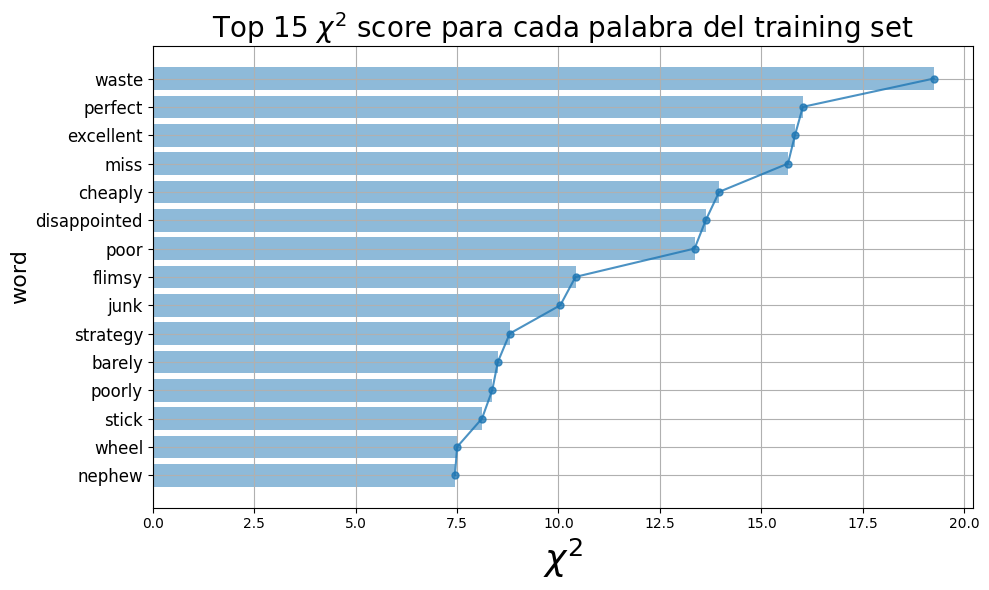

In [ ]:
i = 15

chi2score = chi2(train_df_, train_y)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(10, 6))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score para cada palabra del training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Modelo 1. Predict
##Entrenamiento

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
val_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=2000)
    lr.fit(train_df_, train_y)

    train_predict = lr.predict(train_df_)
    test_predict = lr.predict(test_df_)

    print ("Accuracy TRAIN for C={}: {}".format(c, accuracy_score(train_y, train_predict)))

    print ("Accuracy TEST for C={}: {}".format(c, accuracy_score(test_y, test_predict)))



    train_acc.append(accuracy_score(train_y, train_predict))
    test_acc.append(accuracy_score(test_y, test_predict))

Accuracy TRAIN for C=0.01: 0.8447930574098799
Accuracy TEST for C=0.01: 0.7657657657657657
Accuracy TRAIN for C=0.05: 0.8474632843791722
Accuracy TEST for C=0.05: 0.7737737737737738
Accuracy TRAIN for C=0.25: 0.8601468624833111
Accuracy TEST for C=0.25: 0.7827827827827828
Accuracy TRAIN for C=0.5: 0.8681575433911882
Accuracy TEST for C=0.5: 0.7827827827827828
Accuracy TRAIN for C=1: 0.8888518024032043
Accuracy TEST for C=1: 0.7837837837837838
Accuracy TRAIN for C=10: 0.9536048064085447
Accuracy TEST for C=10: 0.7627627627627628
Accuracy TRAIN for C=100: 0.9753004005340454
Accuracy TEST for C=100: 0.7467467467467468
Accuracy TRAIN for C=1000: 0.9783044058744993
Accuracy TEST for C=1000: 0.7237237237237237
Accuracy TRAIN for C=10000: 0.9783044058744993
Accuracy TEST for C=10000: 0.7197197197197197


###Según estos datos el valor de C más óptimo sería C = 1 donde el en train la precisión es de 0.888 y en test de 0.783 a partir de ahí el modelo sobreajusta y la precisión de Train aumenta pero la de test no y comienza a disminuir

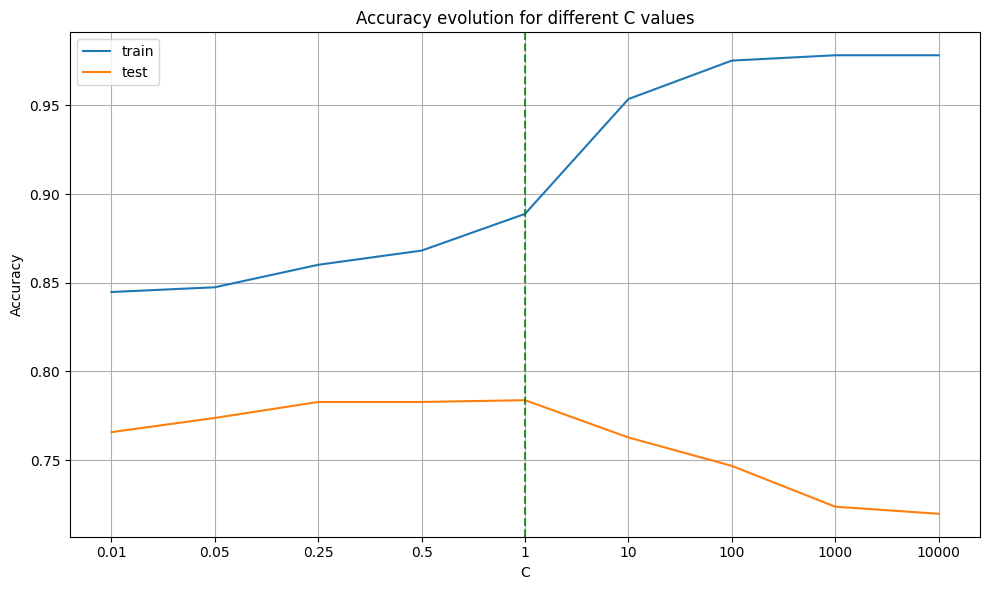

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [ ]:
p, r, thresholds = precision_recall_curve(test_y, test_predict)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(6, 6))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

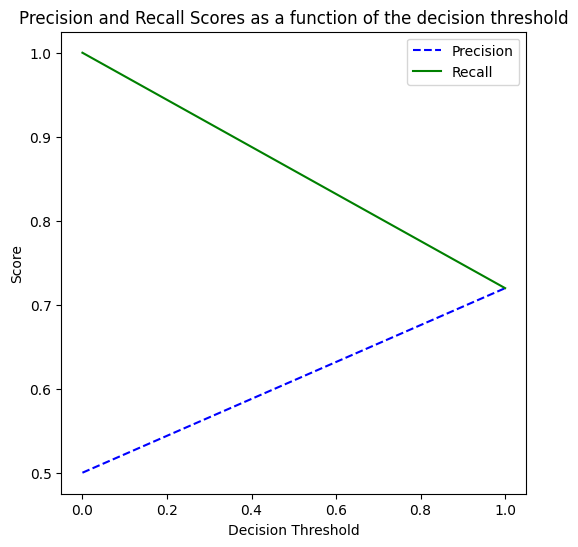

In [ ]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Entrenar el modelo solo con el valor óptimo de C

In [ ]:

optimal_lr = LogisticRegression(C=1, solver='lbfgs', max_iter=2000)
optimal_lr.fit(train_df_, train_y)

train_predict = optimal_lr.predict(train_df_)
test_predict = optimal_lr.predict(test_df_)

print ("Accuracy TRAIN for C={}: {}".format(c, accuracy_score(train_y, train_predict)))
print ("Accuracy TEST for C={}: {}".format(c, accuracy_score(test_y, test_predict)))



train_acc.append(accuracy_score(train_y, train_predict))

test_acc.append(accuracy_score(test_y, test_predict))

Accuracy TRAIN for C=10000: 0.8888518024032043
Accuracy TEST for C=10000: 0.7837837837837838


## Guardamos el modelo

In [ ]:
with open('predictor_model.pkl', 'wb') as f:
    pickle.dump(optimal_lr, f)


In [ ]:
# Guardar el modelo en Google Drive
model_file = "/content/drive/My Drive/"  # Ruta en Google Drive
model.save(model_file,'predictor_model.pkl')

# Algunas métricas

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(test_y, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(test_y, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(test_y, test_predict)))

Confussion matrix:
[[397 102]
 [115 385]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       499
           1       0.79      0.77      0.78       500

    accuracy                           0.78       999
   macro avg       0.78      0.78      0.78       999
weighted avg       0.78      0.78      0.78       999

Accuracy score:0.7827827827827828


### Según estas métricas vemos que el modelo clasifica como buenas correctamente 397 review y 102 erróneamente y 115 clasificados como reviews buenas de manera errónea.
###El F1-score para la clase 0 es de 0.79 y para la 1 es de 0.78




## Aplicamos Modelo y vemos ejemplos de algunas predicciones



In [ ]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['overall_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(optimal_lr.predict(cv.transform([r]))))

In [ ]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, optimal_lr)


Review no. 677
Actual sentiment: 1
Prediction: [1]

Review no. 2821
Actual sentiment: 0
Prediction: [0]

Review no. 3350
Actual sentiment: 0
Prediction: [0]

Review no. 3653
Actual sentiment: 0
Prediction: [0]

Review no. 1273
Actual sentiment: 1
Prediction: [1]


#Modelo 2.GradienBoosting


##CountVectorizer

In [ ]:


nlp = spacy.load("en_core_web_sm")

def tokenize_text(text):
    # Utiliza spaCy para tokenizar el texto y obtener las palabras individuales
    doc = nlp(text)
    return [token.text for token in doc]

def extract_BoW_features(train_text, test_text, vocabulary_size=5000,
                         cache_dir=None, cache_file="bow_features.pkl"):
    """Extrae Bag-of-Words para un conjunto dado de documentos, ya preprocesados en palabras."""
    if cache_dir is not None:
        cache_data = None
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
                print("Se leyeron las características del archivo de caché:", cache_file)
        except:
            pass

        if cache_data is not None:
            return cache_data['features_train'], cache_data['features_test'], cache_data['vocabulary']

    vectorizer = CountVectorizer(max_features=vocabulary_size, tokenizer=tokenize_text)
    features_train = vectorizer.fit_transform(train_text).toarray()
    features_test = vectorizer.transform(test_text).toarray()

    if cache_dir is not None:
        vocabulary = vectorizer.vocabulary_
        cache_data = dict(features_train=features_train, features_test=features_test, vocabulary=vocabulary)
        with open(os.path.join(cache_dir, cache_file), "wb") as f:
            joblib.dump(cache_data, f)
            print("Se escribieron las características en el archivo de caché:", cache_file)

    return features_train, features_test, vectorizer.vocabulary_

# Obtener los textos y etiquetas para train, val y test
train_text, val_text, train_labels, val_labels = train_test_split(df['reviewText'], df['overall_label'], test_size=0.15, random_state=42, stratify=df['overall_label'])
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size=0.25, random_state=42, stratify=train_labels)

# Extraer características Bag-of-Words
features_train, features_test, vocabulary = extract_BoW_features(train_text, test_text)

print("Vocabulario: {} palabras".format(len(vocabulary)))

import random
print("Palabras de muestra: {}".format(random.sample(list(vocabulary.keys()), 8)))

print("\n--- Texto preprocesado ---")
print(train_text.iloc[5])  # Muestra el texto preprocesado en la fila 5 del conjunto de entrenamiento
print("\n--- Características Bag-of-Words ---")
print(features_train[5])  # Muestra las características Bag-of-Words en la fila 5 del conjunto de entrenamiento
print("\n--- Etiqueta ---")
print(train_labels.iloc[5])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulario: 5000 palabras
Palabras de muestra: ['intact', 'solitaire', 'horribly', 'flat', 'intelligent', 'lightweight', 'exasperate', 'urrrgh']

--- Texto preprocesado ---
puzzle great preschool age kid nephew two half use puzzle pretty much every day week start recognize letter different animal object begin letter puzzle little big expect love important part 6months even basically daily use still look new recommend

--- Características Bag-of-Words ---
[0 0 0 ... 0 0 0]

--- Etiqueta ---
0


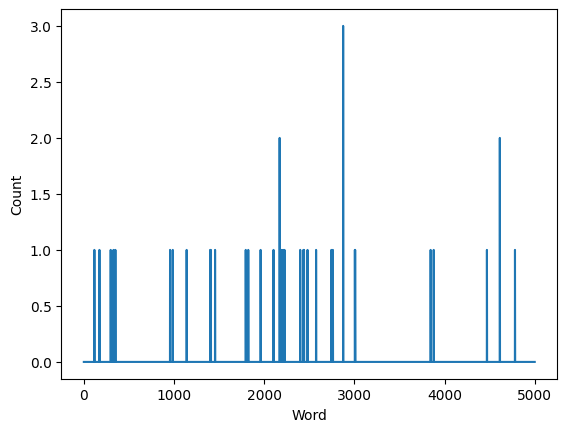

In [ ]:
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

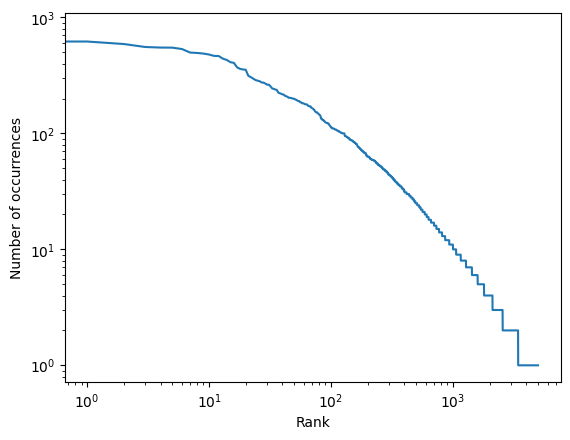

In [ ]:
#Observamos la ley de Zipf
word_freq = features_train.sum(axis=0)

sorted_word_freq = np.sort(word_freq)[::-1]

plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [ ]:
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

#GradientBoosting Entrenamiento

In [ ]:
# Definir el número de estimadores
n_estimators = 32

def classify_gboost(train_df, test_df, train_y, test_y):
    # Inicializar el clasificador GradientBoostingClassifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    # Entrenar el clasificador
    clf.fit(train_df, train_y)

    # Calcular y mostrar la precisión del clasificador en los conjuntos de entrenamiento y prueba
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(train_df, train_y),
            clf.score(test_df, test_y)))

    return clf

# Mezclar los datos de entrenamiento y las etiquetas de entrenamiento simultáneamente
train_features_shuffled, train_labels_shuffled = shuffle(train_df, train_y, random_state=42)

# Crear un objeto CountVectorizer
vectorizer = CountVectorizer()

# Aplicar CountVectorizer a las reseñas de entrenamiento y prueba
train_features_vectorized = vectorizer.fit_transform(train_features_shuffled)
test_features_vectorized = vectorizer.transform(test_df)

# Llamar a la función classify_gboost con las características vectorizadas
clf2 = classify_gboost(train_features_vectorized, test_features_vectorized, train_labels_shuffled, test_y)

[GradientBoostingClassifier] Accuracy: train = 0.8054072096128171, test = 0.8008008008008008


##Guardamos el modelo

In [ ]:
with open('gradient_boosting_model.pkl', 'wb') as f:
    pickle.dump(clf2, f)


#Modelo 3. LSTM

In [ ]:
max = 0
mean = []
for example in train_df:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length


In [ ]:
print(max)



3148


In [ ]:
sum(mean)/len(mean)

158.10046728971963

In [ ]:


max_words = 200  # Longitud máxima de la secuencia

# Crear un Tokenizer y ajustarlo a tus datos de entrenamiento
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df)

# Convertir texto a secuencias de números enteros
train_sequences = tokenizer.texts_to_sequences(train_df)
test_sequences = tokenizer.texts_to_sequences(test_df)

# Llenar las secuencias para que tengan la misma longitud
X_train = pad_sequences(train_sequences, maxlen=max_words)
X_test = pad_sequences(test_sequences, maxlen=max_words)

In [ ]:
words = train_df.str.split().explode().reset_index(drop=True)
vocabulary_size =  len(words)
vocabulary_size

76725

In [ ]:
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           2455200   
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2508501 (9.57 MB)
Trainable params: 2508501 (9.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train[:batch_size], train_y[:batch_size]  # first batch_size samples
X_train2, y_train2 = X_train[batch_size:], train_y[batch_size:]  # rest for training

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

46/46 [==============================] - 17s 312ms/step - loss: 0.6643 - accuracy: 0.5958 - val_loss: 0.5472 - val_accuracy: 0.7656


##Guardamos el modelo

In [ ]:
model_file = "lstm_model.h5"  # HDF5 file
model.save(os.path.join( model_file))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
scores_train = model.evaluate(X_train, train_y, verbose=0)
scores = model.evaluate(X_test, test_y, verbose=0)
print("Train accuracy:", scores_train[1])
print("Test accuracy:", scores[1])

Train accuracy: 0.751335084438324
Test accuracy: 0.7057057023048401


Con estos resultados para esta muestra, me quedaría con el GradientBoosting, los motivos los desarrollo en el notebook de CONCLUSIONES.